# G2 XPCS workflow for beamline 7011 @ ALS running on NERSC


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from BL7011 import g2_fft_t, mean_every_n_frames  # this is where we can call specific things from the beam line, this can be constantly updated
import h5py

# check if gpu is available:
print("CUDA available:", t.cuda.is_available())


class load_data_andor():
    def __init__(self, filename: str, norm="mean", roi=None):
        self.filename = filename
        self.filename_trun = filename.split("/")[-1]
        self.rois = dict()
        with h5py.File(filename, "r") as f:
            if roi == "find":
                patterns = np.squeeze(f["entry1"]["instrument_1"]["detector_1"]["data"][0, 0, :, :])
                plt.imshow(patterns, vmin=np.percentile(patterns, 5), vmax=np.percentile(patterns, 90))
                plt.colorbar()
                plt.show()
                return None, None
    
            elif roi is not None:
                try:
                    patterns = np.squeeze(f["entry1"]["instrument_1"]["detector_1"]["data"][:, :, roi[0]:roi[1], roi[2]:roi[3]])
                except KeyError:
                    # logger.warning(f"Could not roi {roi}")
                    patterns = np.squeeze(f["entry1"]["instrument_1"]["detector_1"]["data"][:, :, :, :])
            else:
                patterns = np.squeeze(f["entry1"]["instrument_1"]["detector_1"]["data"][:10, :10, :, :])
            patterns = patterns.astype(np.float32)
            self.patterns = patterns
            periods = f["entry1"]["instrument_1"]["detector_1"]["period"][()]
            count_time = f["entry1"]["instrument_1"]["detector_1"]["count_time"][()]
            periods += count_time
            # readout_time = f["entry1"]["instrument_1"]["detector_1"]["detector_readout_time"][()]
            temps = f["entry1"]["instrument_1"]["labview_data"]["LS_LLHTA"][()]
            self.temps = temps
    
            # normalize patterns to the mean per frame:
            if norm == "mean":
                patterns_mean = np.mean(patterns, axis=(1, 2))
                # logger.debug(f"patterns_mean shape: {patterns_mean.shape}")
                patterns = patterns / patterns_mean[:, None, None]
                # logger.debug(f"patterns shape: {patterns.shape}")
            elif norm == "sum":
                patterns_sum = np.sum(patterns, axis=(1, 2))
                # logger.debug(f"patterns_sum shape: {patterns_sum.shape}")
                patterns = patterns / patterns_sum[:, None, None]
                # logger.debug(f"patterns shape: {patterns.shape}")
            elif norm == "none":
                pass
            else:
                raise Warning(f"Unknown normalization method: {norm}")
    
        # return patterns, periods, temps


    def plot_sum_frames(self, log=True):
        plt.figure()
        plt.title(self.filename_trun)
        if log:
            plt.imshow(np.log(np.nansum(self.patterns, axis=0)))
        else:
            plt.imshow(np.nansum(self.patterns, axis=0))
        return plt.show()


    def plot_complete_overview(self):
       # Create 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(8, 8))
        
        # Plot 1 (top-left)
        axes[0, 0].imshow(np.log(np.nanmean(self.patterns, axis=0)))
        axes[0, 0].set_title('nanmean')
        
        # Plot 2 (top-right)
        axes[0, 1].plot(np.nanmean(self.patterns, axis=(1,2)))
        axes[0, 1].set_title('stability over time')
        axes[0, 1].set_xlabel('index')
        axes[0, 1].set_ylabel('mean intensity')
        axes[0, 1].grid(True)

        # Plot 3 [temp right now, but can be anything]
        axes[1, 0].plot(self.temps)
        axes[1, 0].set_title('temp stability over time')
        axes[1, 0].set_xlabel('index')
        axes[1, 0].set_ylabel('mean intensity')
        axes[1, 0].grid(True)
        
        # Adjust spacing between subplots
        plt.tight_layout()
        
        # Show the plot
        return plt.show()

    def add_g2_roi(self, new_roi):
        self.rois.update(new_roi)
        

CUDA available: False


In [4]:
datafile = "data/example_data/xpcs_370K_813943d7-b3f7-40f0-8eb1-3711fb861e31.h5"
andor = load_data_andor(datafile)

In [5]:
andor.add_g2_roi({"roi1": [[600, 800], [0,200]]})

/var/folders/qj/nzvr8g992412gwhdx9_f2np00000gn/T/ipykernel_34880/2471605175.py:64: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.nansum(self.patterns, axis=0)))


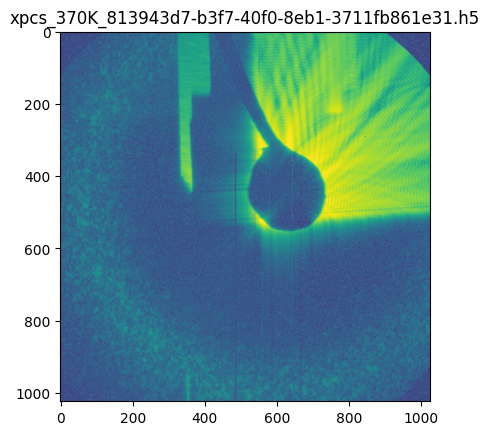

In [6]:
andor.plot_sum_frames()

/tmp/ipykernel_754952/2471605175.py:75: RuntimeWarning: divide by zero encountered in log
  axes[0, 0].imshow(np.log(np.nanmean(self.patterns, axis=0)))


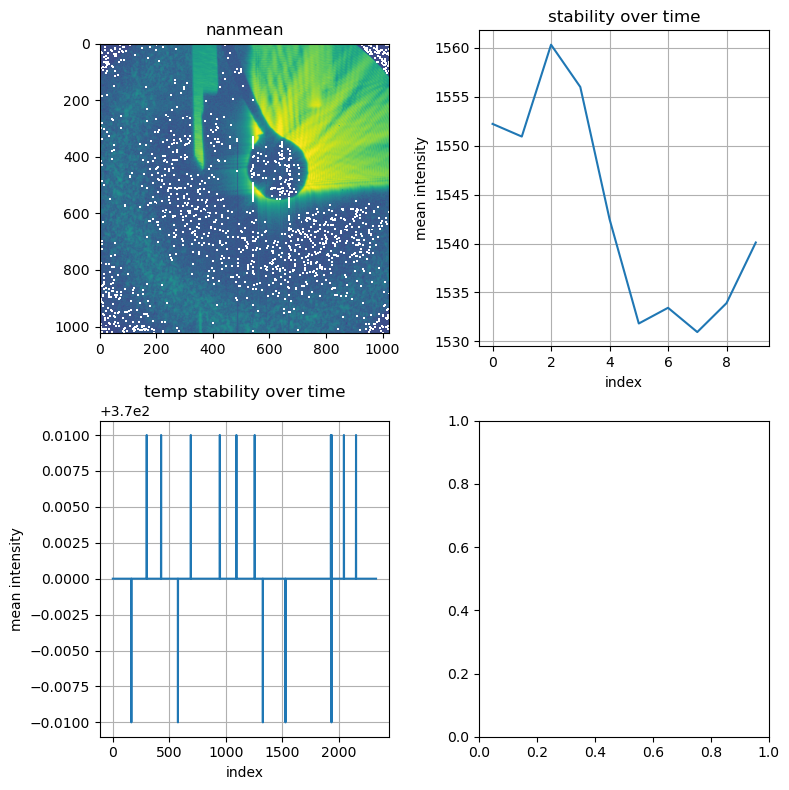

In [39]:
andor.plot_complete_overview()